# Bootstrapping and Bagging

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('data/Heart.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


## Data cleaning

In [3]:
df.dropna(inplace=True)

In [4]:
df.shape

(297, 14)

## Feature Engineering

In [5]:
target = 'AHD'
X = df.drop(target, axis=1)
y = df[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
X_train.columns

Index(['Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
       'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal'],
      dtype='object')

In [8]:
X_train.dtypes

Age            int64
Sex            int64
ChestPain     object
RestBP         int64
Chol           int64
Fbs            int64
RestECG        int64
MaxHR          int64
ExAng          int64
Oldpeak      float64
Slope          int64
Ca           float64
Thal          object
dtype: object

In [9]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer

mapper = DataFrameMapper([
    ('Age', None),
    ('Sex', None),
    ('ChestPain', LabelBinarizer()),
    ('RestBP', None),
    ('Chol', None),
    ('Fbs', None),
    ('RestECG', None),
    ('MaxHR', None),
    ('ExAng', None),
    ('Oldpeak', None),
    ('Slope', None),
    ('Ca', None),
    ('Thal', LabelBinarizer()),
], df_out=True)

mapper.fit(X_train)
Z_train = mapper.transform(X_train)
Z_test = mapper.transform(X_test)

y_train = y_train.replace({'Yes': 1, 'No': 0})
y_test = y_test.replace({'Yes': 1, 'No': 0})

In [10]:
Z_train

,Age,Sex,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal_fixed,Thal_normal,Thal_reversable
66,60,1,0,1,0,0,140,185,0,2,155,0,3.0,2,0.0,0,1,0
105,54,1,0,0,1,0,108,309,0,0,156,0,0.0,1,0.0,0,0,1
160,46,1,0,0,1,0,101,197,1,0,156,0,0.0,1,0.0,0,0,1
147,41,1,0,1,0,0,112,250,0,0,179,0,0.0,1,0.0,0,1,0
19,49,1,0,0,1,0,130,266,0,0,171,0,0.6,1,0.0,0,1,0
294,63,0,1,0,0,0,124,197,0,0,136,1,0.0,2,0.0,0,1,0
79,58,1,1,0,0,0,150,270,0,2,111,1,0.8,1,0.0,0,0,1
213,66,0,1,0,0,0,178,228,1,0,165,1,1.0,2,2.0,0,0,1
138,35,1,1,0,0,0,120,198,0,0,130,1,1.6,2,0.0,0,0,1
72,62,1,1,0,0,0,120,267,0,0,99,1,1.8,2,2.0,0,0,1


In [11]:
np.mean(y_train)

0.46846846846846846

## Model Instantiation

In [12]:
tree = DecisionTreeClassifier()

## Model Evaluation

In [13]:
np.random.seed(1)
cross_val_score(tree, Z_train, y_train, cv=5)

array([0.57777778, 0.86666667, 0.66666667, 0.65909091, 0.72093023])

In [14]:
tree.fit(Z_train, y_train)
tree.score(Z_train, y_train)

1.0

In [15]:
tree.score(Z_test, y_test)

0.8133333333333334

## Ensemble predictions

Let's mimic the "wisdom of the crowds" by creating several Decision Trees and averaging their predictions on the test set.

In [16]:
predictions = pd.DataFrame(index=Z_test.index)

for i in range(1,11):
    t = DecisionTreeClassifier()
    t.fit(Z_train, y_train)
    predictions['Tree {}'.format(i)] = t.predict(Z_test)
    
predictions.head(10)

,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,Tree 10
169,0,0,0,0,0,0,0,0,0,0
214,1,1,1,1,1,1,1,1,1,1
63,0,0,0,0,0,0,0,0,0,0
155,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0,0
77,1,0,0,0,1,0,1,1,1,0
185,1,1,1,1,1,1,1,1,1,1
159,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1
140,1,0,1,0,0,1,0,0,1,0


In [17]:
import random 

predictions = pd.DataFrame(index=Z_test.index)

for i in range(1,11):
    cols = np.random.choice(Z_train.columns, size=8, replace=False)
    Z8_train = Z_train[cols]
    t = DecisionTreeClassifier()
    t.fit(Z8_train, y_train)
    predictions['Tree {}'.format(i)] = t.predict(Z_test[cols])
    
predictions.head(10)

,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,Tree 10
169,0,0,0,1,0,0,0,0,0,0
214,0,0,1,1,0,1,1,0,1,1
63,0,1,1,0,0,0,0,0,0,0
155,0,1,1,1,1,1,1,1,1,1
5,0,0,1,0,0,0,1,0,0,0
77,0,1,0,1,0,0,0,0,0,0
185,0,0,0,1,1,0,0,0,1,1
159,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,0,1,1,0,1,0
140,1,0,0,0,0,1,0,0,0,0


In [18]:
probs = predictions.mean(axis=1)

In [19]:
accuracy_score(y_test, (probs > .5).astype(int))

0.8666666666666667

## Bootstrapping with `numpy`

In [20]:
samples = list(range(1,11))
print(samples)
np.random.choice(samples, size=len(samples))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


array([8, 1, 4, 5, 3, 1, 4, 6, 2, 3])

## Boostrapping with `pandas`

In [21]:
Z_train[:5]

,Age,Sex,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal_fixed,Thal_normal,Thal_reversable
66,60,1,0,1,0,0,140,185,0,2,155,0,3.0,2,0.0,0,1,0
105,54,1,0,0,1,0,108,309,0,0,156,0,0.0,1,0.0,0,0,1
160,46,1,0,0,1,0,101,197,1,0,156,0,0.0,1,0.0,0,0,1
147,41,1,0,1,0,0,112,250,0,0,179,0,0.0,1,0.0,0,1,0
19,49,1,0,0,1,0,130,266,0,0,171,0,0.6,1,0.0,0,1,0


In [22]:
y_train[:5]

66     1
105    0
160    0
147    0
19     0
Name: AHD, dtype: int64

In [23]:
predictions = pd.DataFrame(index=Z_test.index)

for i in range(1,11):
    t = DecisionTreeClassifier()
    ix = np.random.choice(Z_train.index, size=Z_train.shape[0], replace=True)
    ZR_train = Z_train.loc[list(ix)]
    yR_train = y_train.loc[list(ix)]
    t.fit(ZR_train, yR_train)
    predictions['Tree {}'.format(i)] = t.predict(Z_test)
    
predictions.head(10)

,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,Tree 10
169,0,1,0,1,0,0,0,0,0,0
214,1,1,1,0,1,1,1,0,1,1
63,0,0,0,0,0,0,0,0,0,0
155,1,1,0,1,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0,0
77,1,0,0,0,0,1,1,0,0,0
185,0,1,0,1,1,1,1,1,0,0
159,1,1,1,1,0,0,1,0,1,1
9,1,0,1,1,1,0,0,1,1,1
140,0,0,0,0,1,0,0,0,1,0


In [24]:
probs = predictions.mean(axis=1)
accuracy_score(y_test, (probs > .5).astype(int))

0.8

In [25]:
predictions = pd.DataFrame(index=Z_test.index)

for i in range(1,11):
    t = DecisionTreeClassifier()
    ix = np.random.choice(Z_train.index, size=Z_train.shape[0], replace=True)
    ZR_train = Z_train.loc[list(ix)]
    yR_train = y_train.loc[list(ix)]
    t.fit(ZR_train, yR_train)
    predictions['Tree {}'.format(i)] = t.predict(Z_test)
    
predictions.head(10)

,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,Tree 10
169,0,0,0,1,0,0,0,0,0,0
214,1,1,1,1,0,0,1,1,1,0
63,0,0,0,0,0,0,0,0,0,0
155,1,1,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0
77,0,1,0,1,0,1,1,1,1,1
185,0,0,1,0,1,0,0,1,0,1
159,1,1,1,1,0,1,1,1,1,1
9,1,1,0,1,1,1,1,0,1,0
140,1,0,0,0,1,0,0,0,0,0


In [26]:
probs = predictions.mean(axis=1)

In [27]:
accuracy_score(y_test, (probs >= .5).astype(int))

0.76

## Bagging Classifier using `sklearn`

In [28]:
from sklearn.linear_model import LogisticRegression

bag = BaggingClassifier()
bag.fit(Z_train, y_train)
bag.score(Z_train, y_train)
bag.score(Z_test, y_test)

0.8533333333333334

In [29]:
X_train.sample().to_dict(orient='list')

new = pd.DataFrame({
    'Age': [30],
    'Sex': [1],
    'ChestPain': ['asymptomatic'],
    'RestBP': [120],
    'Chol': [234],
    'Fbs': [0],
    'RestECG': [0],
    'MaxHR': [180],
    'ExAng': [0],
    'Oldpeak': [0.1],
    'Slope': [1],
    'Ca': [1.0],
    'Thal': ['reversable']}
)

In [30]:
Z_new = mapper.transform(new)
bag.predict_proba(Z_new)[0][1]

0.6

In [31]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(mapper, bag)
pipe.fit(X_train, y_train)

pipe.predict_proba(X_test)[:, 1]

array([0.3, 0.8, 0.1, 0.7, 0. , 0.6, 0.7, 0.5, 0.6, 0.1, 0.3, 0. , 0.2,
       0.8, 0.6, 0. , 0. , 0.4, 0.8, 0.5, 0.9, 0.8, 1. , 0.4, 1. , 0.4,
       0.9, 0.8, 0.1, 0. , 0. , 0. , 1. , 0.1, 0.3, 0.5, 0.8, 0.1, 1. ,
       0.9, 0.1, 1. , 0.8, 0.8, 0. , 0.2, 0.5, 0.5, 0.3, 0. , 0.4, 0.9,
       0.4, 0.4, 0.6, 0.4, 0. , 0.2, 1. , 1. , 0.1, 0.2, 0.4, 0. , 0. ,
       0.4, 0.7, 0.1, 0.8, 0.8, 1. , 1. , 1. , 0.3, 1. ])

## Titantic

In [32]:
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [33]:
df = pd.read_csv('data/train.csv')

In [34]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [35]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [36]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [37]:
target = 'Survived'
y = df[target]
X = df.drop(target, axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [39]:
mapper = DataFrameMapper([
    ('Pclass', None),
    ('Sex', LabelEncoder()),
    (['Age'], SimpleImputer()),
    ('Fare', None),
    ('Embarked', [CategoricalImputer(), LabelBinarizer()])
], df_out=True)

In [45]:
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

In [46]:
mapper.features[1][1].classes_

array(['female', 'male'], dtype=object)

In [47]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(Z_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [48]:
tree.score(Z_test, y_test)

0.8169491525423729

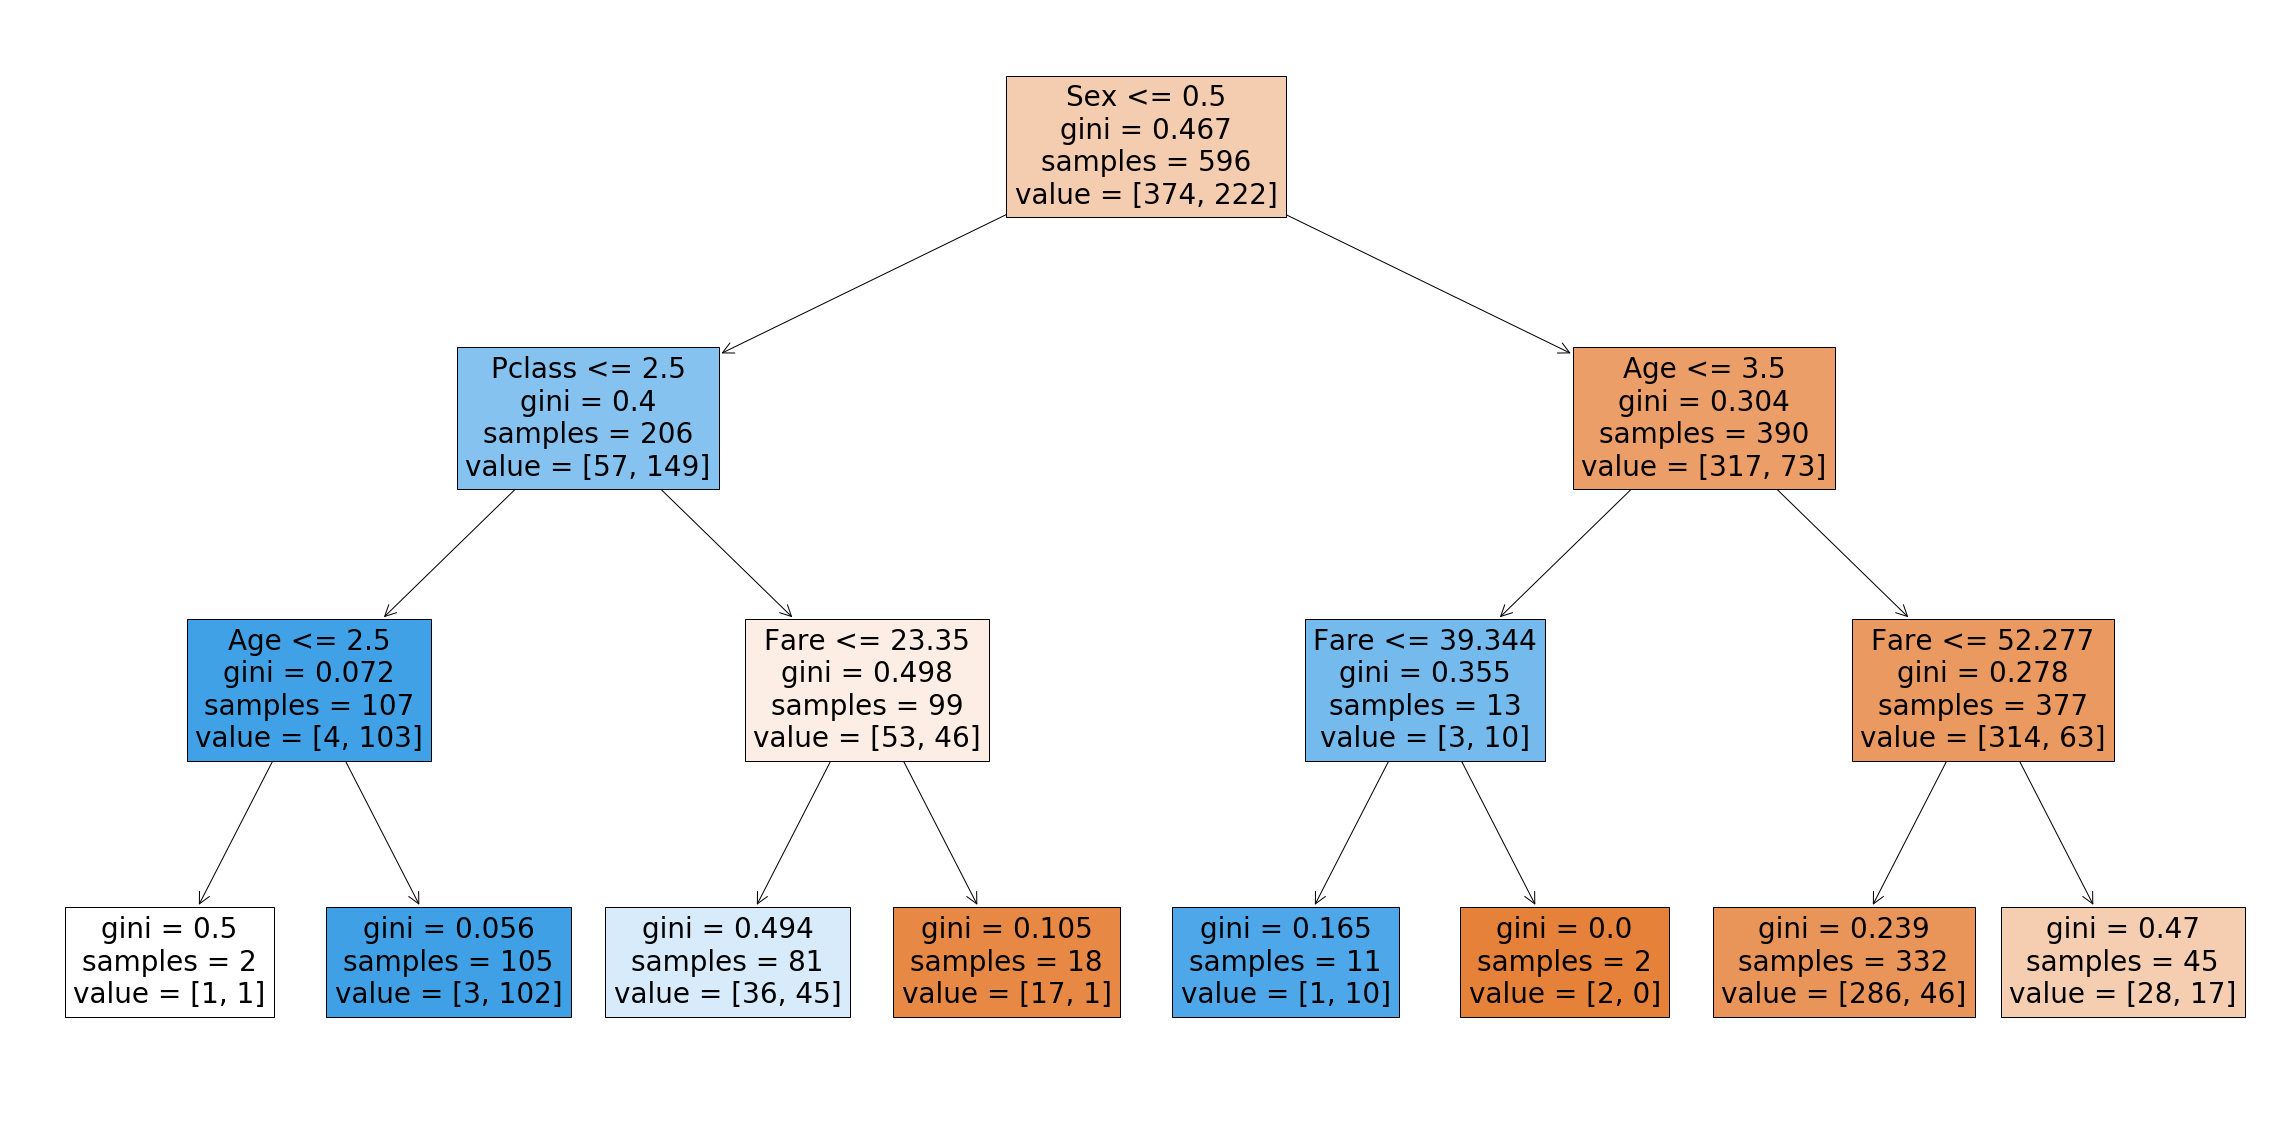

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 20))
plot_tree(tree, feature_names=Z_train.columns, filled=True);

# Additional Notes


### 1) Why would we build an "ensemble model?"
Consider $H$ the space of all possible hypotheses. Our goal is to estimate $f$, the true function. We can come up with different hypotheses $h_1$, $h_2$, and so on to get as close to $f$ as possible. 
- Think about $f$ as the true process that dictates Iowa liquor sales.
- Think about $h_1$ as the model you built to predict $f$.

- The **statistical** benefit to ensemble methods: By building one model, our predictions are almost certainly going to be wrong. Predictions from one model might overestimate liquor sales; predictions from another model might underestimate liquor sales. By "averaging" predictions from multiple models, we'll see that we can often cancel our errors out and get closer to the true function $f$.
- The **computational** benefit to ensemble methods: It might be impossible to develop one model that globally optimizes our objective function. (Remember that CART reach locally-optimal solutions and that all generalized linear models iterate toward a solution that isn't guaranteed to be the globally-optimal solution.) In these cases, it may be impossible for one CART or an individual GLM to arrive at the true function $f$. However, starting our "local searches" at different points and aggregating our predictions might .
- The **representational** benefit to ensemble methods: Even if we had all the data and all the computer power in the world, it might be impossible for one model to exactly equal $f$. For example, a linear regression model can never model a relationship where a one-unit change in $X$ effects some *different* change in $Y$ based on the value of $X$. All models have some shortcomings. (See [the no free lunch theorems](https://en.wikipedia.org/wiki/No_free_lunch_in_search_and_optimization).) While individual models have shortcomings, by creating multiple models and aggregating their predictions, we can actually create predictions that represent something that one model cannot ever represent.


### 2) What do you mean by "aggregate prediction?"
As with all of our modeling techniques, we want to make sure that we can come up with one final prediction for our observation. (Building 1,000 trees and coming up with 1,000 predictions for one observation probably wouldn't be very helpful.)

Suppose we want to predict whether or not a Reddit post is going to go viral, where `1` indicates viral and `0` indicates non-viral. We build 100 decision trees. Given a new Reddit post labeled `X_test`, we pass these features into all 100 decision trees.
- 70 of the trees predict that the post in `X_test` will go viral.
- 30 of the trees predict that the post in `X_test` will not go viral.